<a href="https://colab.research.google.com/github/Rahul19982022/anime-recommendation-system-exp/blob/main/recommendation_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
!pip install -q pandas==2.2.2
!pip install -q numpy==2.0.2
!pip install -q scipy==1.15.3
!pip install -q tensorflow==2.18.0

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from numpy.linalg import norm

In [ ]:
from scipy import stats
from scipy.spatial import distance

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
import tensorflow
import tensorflow.keras

In [ ]:
from sentence_transformers import util

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# put path of your project folder here

proj_path = '/content/drive/MyDrive/anime_recommendation_system'
os.chdir(proj_path)

### Load Data

In [ ]:
user = pd.read_pickle('datasets/created_datasets/user.pkl')
anime = pd.read_pickle('datasets/created_datasets/anime.pkl')

In [ ]:
content_df_path = 'datasets/created_datasets/content_df_model.pkl'

with open(content_df_path, 'rb') as f:
    content_df = pickle.load(f)

In [ ]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59516292 entries, 0 to 59516291
Data columns (total 5 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user_id    uint32
 1   anime_id   uint16
 2   rating     uint8 
 3   user_enc   Int32 
 4   anime_enc  uint16
dtypes: Int32(1), uint16(2), uint32(1), uint8(1)
memory usage: 794.6 MB


In [ ]:
user.head(7)

,user_id,anime_id,rating,user_enc,anime_enc
0,0,67,9,0,0
1,0,6702,7,0,1
2,0,242,10,0,2
3,0,24,9,0,3
4,0,4722,8,0,4
5,0,6098,6,0,5
6,0,3125,9,0,6


In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6356 entries, 0 to 6355
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         6356 non-null   int64 
 1   Name           6356 non-null   object
 2   Score          6356 non-null   object
 3   Genres         6356 non-null   object
 4   English name   6356 non-null   object
 5   Japanese name  6356 non-null   object
 6   Type           6356 non-null   object
 7   Episodes       6356 non-null   object
 8   Aired          6356 non-null   object
 9   Premiered      6356 non-null   object
 10  Producers      6356 non-null   object
 11  Licensors      6356 non-null   object
 12  Studios        6356 non-null   object
 13  Source         6356 non-null   object
 14  Duration       6356 non-null   object
 15  Rating         6356 non-null   object
 16  Ranked         6356 non-null   object
 17  Popularity     6356 non-null   int64 
 18  Members        6356 non-null

In [ ]:
content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9262 entries, 0 to 9261
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   MAL_ID           9262 non-null   int64 
 1   final_plot       9262 non-null   object
 2   Name             9262 non-null   object
 3   plot_embeddings  9262 non-null   object
dtypes: int64(1), object(3)
memory usage: 289.6+ KB


In [ ]:
content_df.head()

,MAL_ID,final_plot,Name,plot_embeddings
0,1,"In the year 2071, roughly fifty years after an...",Cowboy Bebop,"[-0.6200249, 0.099920556, -0.57617146, -0.0361..."
1,5,"A few days before Halloween on Mars, Faye witn...",Cowboy Bebop: Tengoku no Tobira,"[-0.9318227, -0.39293668, 0.8494157, -0.246592..."
2,6,"In the 32nd century, a man known as ""Vash the ...",Trigun,"[-0.86476064, -0.23550393, 0.4500971, -0.09877..."
3,7,"Robin Sena is a ""craft user"", born in Japan an...",Witch Hunter Robin,"[-1.0203842, -0.2030842, 0.19262214, 0.1093473..."
4,8,"Set in the Dark Ages, a term referring to the ...",Bouken Ou Beet,"[-0.45977286, -0.5685828, -0.024093034, 0.2058..."


In [ ]:
content_df = content_df[content_df['MAL_ID'].isin(anime['MAL_ID'].unique())]
content_df.reset_index(inplace = True, drop = True)
content_df.head()

,MAL_ID,final_plot,Name,plot_embeddings
0,1,"In the year 2071, roughly fifty years after an...",Cowboy Bebop,"[-0.6200249, 0.099920556, -0.57617146, -0.0361..."
1,5,"A few days before Halloween on Mars, Faye witn...",Cowboy Bebop: Tengoku no Tobira,"[-0.9318227, -0.39293668, 0.8494157, -0.246592..."
2,6,"In the 32nd century, a man known as ""Vash the ...",Trigun,"[-0.86476064, -0.23550393, 0.4500971, -0.09877..."
3,7,"Robin Sena is a ""craft user"", born in Japan an...",Witch Hunter Robin,"[-1.0203842, -0.2030842, 0.19262214, 0.1093473..."
4,8,"Set in the Dark Ages, a term referring to the ...",Bouken Ou Beet,"[-0.45977286, -0.5685828, -0.024093034, 0.2058..."


### Preprocessing Data

Before we build our features for Recommendation, we need some analysis of some <br> columns, also creating new columns and dataframes which will be helpful

#### 1. Cleaning 'Genres' Column

In [ ]:
# Let's inspect Genres column in anime, as it is an important column
anime['Genres'].head()

,Genres
0,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
1,"Action, Drama, Mystery, Sci-Fi, Space"
2,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen"
3,"Action, Mystery, Police, Supernatural, Drama, ..."
4,"Adventure, Fantasy, Shounen, Supernatural"


In [ ]:
# we split the genres where ',' is present,
# and then split them again based on ' '
# so that we are sure comma is present in every data properly
# And if comma is not present like for Ex. Shounen Action, we ccovert it to
# Shounen, Action or better we will use '|' as separator

genre_insp = pd.Series((' ').join(anime['Genres']).split(', ')).str.split(' ')
genre_insp[genre_insp.apply(lambda x: True if len(x) > 1 else False)].value_counts().head(25)

,count
"[Shounen, Action]",413
"[Super, Power]",234
"[Shounen, Comedy]",214
"[Martial, Arts]",173
"[Seinen, Action]",172
"[Slice, of, Life]",158
"[Fantasy, Action]",150
"[Supernatural, Action]",150
"[Shounen, Adventure]",142
"[Sci-Fi, Action]",142


In [ ]:
anime['Genres_edited'] = anime['Genres'].copy()

anime['Genres_edited'] = anime['Genres_edited'].str.replace('Slice of Life', 'Slice-of-Life')
anime['Genres_edited'] = anime['Genres_edited'].str.replace('Martial Arts', 'Martial-Arts')
anime['Genres_edited'] = anime['Genres_edited'].str.replace('Super Power', 'Super-Power')

In [ ]:
def space_split_genres(genres):
    '''
    Function to assure no space between words in genres and using '|' as separator
    Input: str
    Output: str
    '''

    # 'Comedy, Shounen Aciton will convert to 'Action|Comedy|Shounen'
    genres_edited = genres.copy()
    for i in range(len(genres)):
        if ' ' in genres[i]:
            genres_edited = genres_edited[0:i] + genres[i].split(' ') + genres[i+1:]
    return ('|').join(sorted(genres_edited))

In [ ]:
anime['Genres_edited'] = anime['Genres_edited'].str.split(', ').apply(space_split_genres)

In [ ]:
anime['Genres_edited'].head(5)

,Genres_edited
0,Action|Adventure|Comedy|Drama|Sci-Fi|Space
1,Action|Drama|Mystery|Sci-Fi|Space
2,Action|Adventure|Comedy|Drama|Sci-Fi|Shounen
3,Action|Drama|Magic|Mystery|Police|Supernatural
4,Adventure|Fantasy|Shounen|Supernatural


In [ ]:
genre_value_counts = pd.Series(('|').join(anime['Genres_edited']).split('|')).value_counts()
genre_value_counts

,count
Comedy,3036
Action,2241
Fantasy,1508
Drama,1476
Shounen,1419
Adventure,1389
Sci-Fi,1362
Romance,1356
School,1106
Supernatural,961


In [ ]:
# Let's grab names of the genres present, we are ignoring 'Unknown' genre

genres_list = genre_value_counts.index.tolist()[:-1]
print(genres_list)

['Comedy', 'Action', 'Fantasy', 'Drama', 'Shounen', 'Adventure', 'Sci-Fi', 'Romance', 'School', 'Supernatural', 'Slice-of-Life', 'Magic', 'Ecchi', 'Seinen', 'Mecha', 'Mystery', 'Shoujo', 'Super-Power', 'Historical', 'Military', 'Sports', 'Harem', 'Horror', 'Psychological', 'Parody', 'Music', 'Space', 'Demons', 'Kids', 'Martial-Arts', 'Game', 'Police', 'Ai', 'Vampire', 'Samurai', 'Thriller', 'Josei', 'Dementia', 'Cars', 'Yaoi']


####2. Building Encoded dataframe of genres

In [ ]:
# Let's create Encoded dataframe of genres

genres_mlb = MultiLabelBinarizer(classes = genres_list)
anime_genres_mlb = anime[['MAL_ID', 'Genres_edited']].copy()

anime_genres_mlb_temp = pd.DataFrame(genres_mlb.fit_transform(anime_genres_mlb['Genres_edited'].str.split('|')), columns = genres_mlb.classes_)
anime_genres_mlb = anime_genres_mlb.join(anime_genres_mlb_temp)
anime_genres_mlb.head()

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Unknown'] will be ignored
  warnings.warn(


,MAL_ID,Genres_edited,Comedy,Action,Fantasy,Drama,Shounen,Adventure,Sci-Fi,Romance,...,Game,Police,Ai,Vampire,Samurai,Thriller,Josei,Dementia,Cars,Yaoi
0,1,Action|Adventure|Comedy|Drama|Sci-Fi|Space,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,5,Action|Drama|Mystery|Sci-Fi|Space,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,6,Action|Adventure|Comedy|Drama|Sci-Fi|Shounen,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7,Action|Drama|Magic|Mystery|Police|Supernatural,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,8,Adventure|Fantasy|Shounen|Supernatural,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


####3. Building aggregrated dataframes for user and anime data

In [ ]:
# Let's create user_agg (i.e. user aggregrate)

user_agg = user.groupby('user_id').agg(animes_watched = ('anime_id', 'count'),
                                      user_avg_rating = ('rating', 'mean')).reset_index()
user_agg.head()

,user_id,animes_watched,user_avg_rating
0,0,40,7.725000
1,1,117,8.051282
2,2,46,8.521739
3,3,317,7.611987
4,4,120,7.633333


In [ ]:
# Create anime aggregrate dataframe

anime_agg = user.groupby('anime_id')['rating'].agg(['mean', 'count']).reset_index()
anime_agg.columns = ['anime_id', 'anime_avg_rating', 'total_ratings_anime']
anime_agg.head()

,anime_id,anime_avg_rating,total_ratings_anime
0,1,8.668267,86648
1,5,8.318500,33617
2,6,8.167207,50279
3,7,7.265829,11624
4,8,6.935718,1789


####4. Building parameter 'rating_diff'

<b>rating_diff</b> will reflect how much the user enjoyed the anime \
keeping in mind both the genreal consensus regarding the anime
and average rating given by user

In [ ]:
user['anime_avg_rating'] = user['anime_id'].map(anime_agg.set_index('anime_id')['anime_avg_rating']).astype('float32')
user['user_avg_rating'] = user['user_id'].map(user_agg.set_index('user_id')['user_avg_rating']).astype('float32')

In [ ]:
user.head()

,user_id,anime_id,rating,user_enc,anime_enc,anime_avg_rating,user_avg_rating
0,0,67,9,0,0,7.557934,7.725
1,0,6702,7,0,1,7.646535,7.725
2,0,242,10,0,2,7.378310,7.725
3,0,24,9,0,3,7.976726,7.725
4,0,4722,8,0,4,8.248917,7.725


In [ ]:
# Creating rating_diff, which will be average of rating_diff_wrt_anime and rating_diff_wrt_user
# rating_diff will reflect how much the user enjoyed the anime
# (keeping in mind both the genreal consensus regarding the anime and average rating given by user)

user['rating_diff_wrt_anime'] = user['rating'] - user['anime_avg_rating']
user['rating_diff_wrt_user'] = user['rating'] - user['user_avg_rating']
user['rating_diff'] = 0.5*(user['rating_diff_wrt_anime'] + user['rating_diff_wrt_user']).astype('float32')

In [ ]:
user.drop(['anime_avg_rating', 'user_avg_rating', 'rating_diff_wrt_anime', 'rating_diff_wrt_user'], inplace = True, axis = 1)

In [ ]:
user.head()

,user_id,anime_id,rating,user_enc,anime_enc,rating_diff
0,0,67,9,0,0,1.358533
1,0,6702,7,0,1,-0.685767
2,0,242,10,0,2,2.448345
3,0,24,9,0,3,1.149137
4,0,4722,8,0,4,0.013042


####5. Extracting Origin Year of the anime from the 'Aired' Column

In [ ]:
anime['Aired'].head(10)

,Aired
0,"Apr 3, 1998 to Apr 24, 1999"
1,"Sep 1, 2001"
2,"Apr 1, 1998 to Sep 30, 1998"
3,"Jul 2, 2002 to Dec 24, 2002"
4,"Sep 30, 2004 to Sep 29, 2005"
5,"Apr 6, 2005 to Mar 19, 2008"
6,"Apr 15, 2005 to Sep 27, 2005"
7,"Sep 11, 2002 to Sep 10, 2003"
8,"Apr 17, 2004 to Feb 18, 2006"
9,"Apr 7, 2004 to Sep 28, 2005"


In [ ]:
def year_finding(aired):

    '''
    extracting year from Aired column
    Input: str
    Output: int
    '''
    if aired == 'Unknown':
        return -1
    match = re.search(r'([1-2][0-9]{3})', aired)
    if match is not None:
        return int(match.group(0))
    else:
        return -2

In [ ]:
anime['Origin_year'] = anime['Aired'].apply(lambda x: year_finding(str(x))).astype('int16')

In [ ]:
anime['Origin_year'].value_counts().sort_index().head(10)

,count
Origin_year,
-1,1
1917,1
1918,1
1929,1
1930,1
1931,3
1943,1
1958,1
1962,3


In [ ]:
anime[anime['Origin_year'] == -1]

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Genres_edited,Origin_year
5060,33187,Katsudou Shashin,5.48,Unknown,Unknown,活動写真,Movie,1,Unknown,Unknown,...,84.0,245.0,407.0,956.0,202.0,165.0,155.0,261.0,Unknown,-1


In [ ]:
anime.loc[anime['Origin_year'] == -1, 'Origin_year'] = 1907

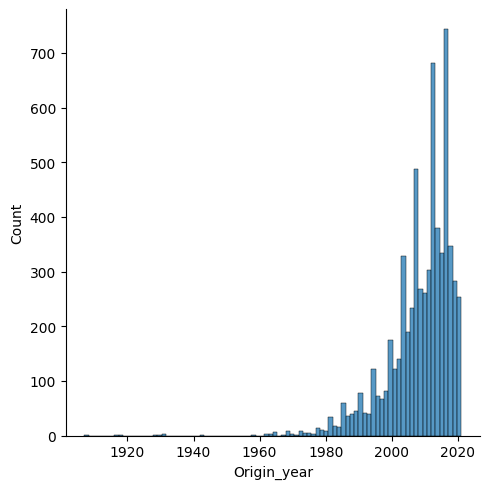

In [ ]:
sns.displot(data = anime['Origin_year'])

In [ ]:
anime['Popularity_adjusted'] = anime['Popularity'].rank(method = 'dense').astype('int')

In [ ]:
anime['Popularity_adjusted'].head()

,Popularity_adjusted
0,34
1,391
2,163
3,1056
4,2929


## Building Recommendation Features

In [ ]:
def get_anime_id_from_name(name):
    try:
        return anime[anime['Name'] == name]['MAL_ID'].values[0]
    except:
        try:
            return anime[anime['English name'] == name]['MAL_ID'].values[0]
        except:
            print('Anime not found')
            return None

In [ ]:
def get_anime_name_from_id(anime_id):
    try:
        return anime[anime['MAL_ID'] == anime_id]['Name'].values[0]
    except:
        print('Anime not found')
        return None

In [ ]:
user_ids_model = user[user['user_enc'].notna()]['user_id'].unique().tolist()
user_ids_complete = user['user_id'].unique().tolist()

In [ ]:
def get_random_user_id(user_ids = user_ids_model):
    return np.random.choice(user_ids)

#### Function for filtering Recommendations

In [ ]:
def filter_recommendations(recommendations, anime, anime_agg, Type_preferred = None, Genres_preferred = None, Origin_year_range = None,
                           Popularity_range = None, min_anime_rating = None):

      '''
      Function to filter recommendations based on user preferences
      Input:
      recommendations: pd.DataFrame
      anime: pd.DataFrame
      anime_agg: pd.DataFrame
      Type_preferred: list          Ex. ['TV', 'Movie']
      Genres_preferred: list        Ex. ['Action', 'Adventure']
      Origin_year_range: list       Ex. [1990, 2000]
      Popularity_range: list        Ex. [100, 200]
      min_anime_rating: float       Ex. 8.5
      Output: pd.DataFrame
      '''
      if recommendations is None:
          print('No recommendations found')
          return None

      if 'anime_id' in recommendations.columns:
          recommendations = recommendations.merge(anime[['MAL_ID', 'Name', 'English name', 'Type', 'Genres_edited', 'Origin_year',
                                                    'Popularity_adjusted']], left_on = 'anime_id', right_on = 'MAL_ID', how = 'left')
          recommendations = recommendations.drop('anime_id', axis = 1)
      else:
          recommendations = recommendations.merge(anime[['MAL_ID', 'Name', 'English name', 'Type', 'Genres_edited', 'Origin_year',
                                                    'Popularity_adjusted']], how = 'left')

      if 'anime_avg_rating' not in recommendations.columns:
          recommendations = recommendations.merge(anime_agg[['anime_id', 'anime_avg_rating']], left_on = 'MAL_ID', right_on = 'anime_id', how = 'left')
          recommendations = recommendations.drop('anime_id', axis = 1)

      if Type_preferred is not None:
          recommendations = recommendations[recommendations['Type'].isin(Type_preferred)]
      if Genres_preferred is not None:
          recommendations = recommendations[recommendations['Genres_edited'].str.split('|').apply(lambda x: True if set(Genres_preferred).issubset(x) else False)]
      if Origin_year_range is not None:
          recommendations = recommendations[(recommendations['Origin_year'] >= Origin_year_range[0]) & (recommendations['Origin_year'] <= Origin_year_range[1])]
      if Popularity_range is not None:
          recommendations = recommendations[(recommendations['Popularity_adjusted'] >= Popularity_range[0]) & (recommendations['Popularity_adjusted'] <= Popularity_range[1])]
      if min_anime_rating is not None:
          recommendations = recommendations[recommendations['anime_avg_rating'] >= min_anime_rating]

      recommendations = recommendations.reset_index(drop = True)

      recommendations = recommendations[['MAL_ID', 'Name', 'English name', 'Genres_edited', 'Type',  'Origin_year',
                                         'anime_avg_rating', 'Popularity_adjusted']]
      return recommendations


### 1.Model Based Features

In [ ]:
# Let's load our trained model

checkpoint_filepath = 'model/checkpoint.model.keras'

model = tensorflow.keras.models.load_model(checkpoint_filepath)

In [ ]:
# Let's load our encodings of the categorical data

user2user_encoded = pickle.load(open('datasets/created_datasets/encoded_dictionary/user2user_encoded.pkl', 'rb'))
user_encoded2user = pickle.load(open('datasets/created_datasets/encoded_dictionary/user_encoded2user.pkl', 'rb'))
anime2anime_encoded = pickle.load(open('datasets/created_datasets/encoded_dictionary/anime2anime_encoded.pkl', 'rb'))
anime_encoded2anime = pickle.load(open('datasets/created_datasets/encoded_dictionary/anime_encoded2anime.pkl', 'rb'))

In [ ]:
encoded_dictionary = {'user2user_encoded': user2user_encoded,
                      'user_encoded2user': user_encoded2user,
                      'anime2anime_encoded': anime2anime_encoded,
                      'anime_encoded2anime': anime_encoded2anime}

In [ ]:
# Load weights from the model

def extract_weights(layer_name, model):
    weight_layer = model.get_layer(layer_name)
    weights = weight_layer.get_weights()[0]
    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [ ]:
selected_user_id_1 = get_random_user_id()
print(selected_user_id_1)

353075


#### 1.1 Recommendation based on Rating Prediction by Model

In [ ]:
def model_rec_based_on_rating_prediction(selected_user_id, anime, user, encoded_dictionary, model):
    """
    Generates anime recommendations for a user based on predicted ratings from a deep learning model.

    Parameters:
    -----------
    selected_user_id : int
        The ID of the user for whom recommendations are to be generated.
    anime : DataFrame
    user : DataFrame
    encoded_dictionary : dict
        A dictionary containing:
            - 'anime2anime_encoded': mapping from actual anime IDs to encoded indices.
            - 'anime_encoded2anime': reverse mapping from encoded indices back to actual anime IDs.
            - 'user2user_encoded': mapping from actual user IDs to encoded indices.
            - 'user_encoded2user': reverse mapping from encoded indices back to actual user IDs.
    model : keras.Model
        The trained collaborative filtering model that predicts ratings using user and anime embeddings.

    Returns:
    --------
    DataFrame
        A sorted dataframe of animes not yet watched by the user, along with their predicted ratings.
    """

    try:
        # Get encoded user ID from dictionary
        selected_user_id_enc = encoded_dictionary['user2user_encoded'].get(selected_user_id)
    except:
        print('User not found')
        return

    # Create a DataFrame of unwatched animes
    selected_user_id_animes_not_watched = pd.DataFrame(list(set(anime['MAL_ID'].unique()) - set(user[user['user_id'] == selected_user_id]['anime_id'].tolist())))
    selected_user_id_animes_not_watched.columns = ['anime_id']

    # Encode anime IDs using the provided dictionary
    selected_user_id_animes_not_watched['anime_enc'] = selected_user_id_animes_not_watched['anime_id'].map(encoded_dictionary['anime2anime_encoded'])

    # Predict ratings for all unwatched animes using the model
    predictions = model.predict([
        np.array([selected_user_id_enc] * len(selected_user_id_animes_not_watched)),  # user input
        np.array(selected_user_id_animes_not_watched['anime_enc'].tolist())            # anime input
    ])

    # Store predictions in the dataframe
    selected_user_id_animes_not_watched['rating_prediction'] = predictions

    # Sort animes based on predicted rating (highest first)
    recommendations = selected_user_id_animes_not_watched.sort_values(by='rating_prediction', ascending=False)

    return recommendations


In [ ]:
recommendations = model_rec_based_on_rating_prediction(selected_user_id_1, anime, user, encoded_dictionary, model)
recommendations

178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,anime_id,anime_enc,rating_prediction
5015,12355,851,8.771486
343,431,17,8.677898
4627,9989,197,8.585656
3184,5114,71,8.486181
489,585,512,8.478565
...,...,...,...
1571,18231,5515,3.310741
1683,1995,4184,3.231634
4314,41124,6202,3.209857
2757,36847,3892,3.119555


In [ ]:
filter_recommendations(recommendations, anime, anime_agg, Type_preferred = ['TV', 'Movie'], Genres_preferred = ['Action', 'Adventure']).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,5114,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist:Brotherhood,Action|Adventure|Comedy|Drama|Fantasy|Magic|Mi...,TV,2009,9.148895,3
1,11061,Hunter x Hunter (2011),Hunter x Hunter,Action|Adventure|Fantasy|Shounen|Super-Power,TV,2011,9.049059,12
2,25013,Akatsuki no Yona,Yona of the Dawn,Action|Adventure|Comedy|Fantasy|Romance|Shoujo,TV,2014,8.019614,151
3,9204,Omae Umasou da na,You Are Umasou,Action|Adventure|Fantasy|Kids,Movie,2010,7.978528,2867
4,1033,Sennen Joyuu,Millennium Actress,Action|Adventure|Drama|Fantasy|Historical|Romance,Movie,2002,8.267345,851
5,2418,Stranger: Mukou Hadan,Sword of the Stranger,Action|Adventure|Historical|Samurai,Movie,2007,8.312847,418
6,36649,Banana Fish,Unknown,Action|Adventure|Drama|Shoujo,TV,2018,8.119282,250
7,31339,Drifters,Drifters,Action|Adventure|Comedy|Fantasy|Historical|Sam...,TV,2016,7.814964,252
8,3673,Nijuu Mensou no Musume,The Daughter of 20 Faces,Action|Adventure|Mystery,TV,2008,7.567745,2049
9,16524,Suisei no Gargantia,Gargantia on the Verdurous Planet,Action|Adventure|Mecha|Sci-Fi,TV,2013,7.561994,375


#### 1.2 Recommendation using User-User Similarity via Embeddings

In [ ]:
def model_rec_based_on_user_similarity(user_id, user_weights, encoded_dictionary, user, anime,
                                       sort_by='rating_mean', top_n_similar_users=100, user_threshold_for_rec=20):
    """
    Recommends anime to a user based on preferences of similar users using user embedding similarity.

    Parameters:
    -----------
    user_id : int
        The target user ID for whom we want to generate recommendations.
    user_weights : np.ndarray
        The embedding matrix of users from the trained deep learning model.
        Each row represents an encoded user.
    encoded_dictionary : dict
        Dictionary containing:
            - 'user2user_encoded': mapping from real user IDs to encoded indices.
            - 'user_encoded2user': reverse mapping from encoded indices to real user IDs.
            - 'anime2anime_encoded': mapping from real anime IDs to encoded indices.
            - 'anime_encoded2anime': reverse mapping from encoded indices to real anime IDs.
    user : pd.DataFrame
    anime : pd.DataFrame
    sort_by : str (default='rating_mean')
        The column to sort recommendations by. Options include 'rating_mean', 'users_watched' and 'rating_diff_mean'.
    top_n_similar_users : int (default=100)
        Number of most similar users to consider for making recommendations.
    user_threshold_for_rec : int (default=20)
        Minimum number of users who must have rated an anime for it to be considered as a recommendation.

    Returns:
    --------
    pd.DataFrame
        A DataFrame of recommended anime (not watched by the user) along with aggregated rating stats
        from similar users, sorted by the chosen metric.
    """

    try:
        # Get encoded index for the input user
        encoded_index = encoded_dictionary['user2user_encoded'].get(user_id)

        # normalize the embeddings, so cosine similarity with other
        # anime embeddings will simply be dot product
        user_weights_norm = user_weights/np.linalg.norm(user_weights, axis = 1).reshape((-1, 1))
        dists = np.dot(user_weights_norm, user_weights_norm[encoded_index])

        # Get indices of top N similar users (excluding the user themselves)
        sorted_dists = np.argsort(dists)
        top_n_similar_user_encoded_index = list(sorted_dists[-1:-(top_n_similar_users + 2):-1])
        top_n_similar_user_encoded_index.remove(encoded_index)

        # Decode back to original user IDs
        top_n_similar_user_ids = [encoded_dictionary['user_encoded2user'].get(i) for i in top_n_similar_user_encoded_index]

        # Filter data for these similar users
        relevant_user_data = user[user['user_id'].isin(pd.Series(top_n_similar_user_ids))]

        # Exclude animes already watched by the target user
        relevant_user_data = relevant_user_data[
            ~relevant_user_data['anime_id'].isin(user[user['user_id'] == user_id]['anime_id'])
        ]

        # Group by anime and calculate stats from ratings
        relevant_user_data_grouped = relevant_user_data.groupby('anime_id').agg(
            users_watched=('rating', 'count'),
            rating_mean=('rating', lambda x: stats.trim_mean(x, 0.05)),  # trim mean to reduce outlier impact
            rating_diff_mean=('rating_diff', lambda y: stats.trim_mean(y, 0.05))
        )

        # Clean up result
        relevant_user_data_grouped = relevant_user_data_grouped.reset_index()
        relevant_user_data_grouped['rating_diff_mean'] = relevant_user_data_grouped['rating_diff_mean'].astype(np.float64)

        # Filter animes rated by at least `user_threshold_for_rec` users
        relevant_user_data_grouped = relevant_user_data_grouped[
            relevant_user_data_grouped['users_watched'] >= user_threshold_for_rec
        ]

        # Sort by chosen metric
        relevant_user_data_grouped = relevant_user_data_grouped.sort_values(
            by=sort_by, ascending=False
        )

        return relevant_user_data_grouped

    except Exception as e:
        print(e)
        return


In [ ]:
selected_user_id_2 = get_random_user_id()
selected_user_id_2

np.int64(232935)

In [ ]:
rec_based_on_user_sim_via_model_embeddings = model_rec_based_on_user_similarity(
                                              selected_user_id_2, user_weights, encoded_dictionary, user, anime,
                                              sort_by = 'rating_diff_mean',
                                              top_n_similar_users=200, user_threshold_for_rec = 30)
rec_based_on_user_sim_via_model_embeddings.head(10)

,anime_id,users_watched,rating_mean,rating_diff_mean
1604,11577,44,9.525000,1.266380
1439,9989,68,9.483871,1.224116
1374,9253,113,9.844660,1.216319
2549,31240,76,9.328571,1.169786
693,1889,37,9.342857,1.144009
2935,34599,30,9.535714,1.134253
3288,38524,30,9.678571,1.126897
1560,10863,48,9.272727,1.112962
3182,37450,33,9.161290,1.100171
107,164,41,9.351351,1.045572


In [ ]:
filter_recommendations(rec_based_on_user_sim_via_model_embeddings, anime, anime_agg).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,11577,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,Steins;Gate:The Movie − Load Region of Déjà Vu,Drama|Sci-Fi,Movie,2013,8.503066,227
1,9989,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,anohana:The Flower We Saw That Day,Drama|Slice-of-Life|Supernatural,TV,2011,8.427240,46
2,9253,Steins;Gate,Steins;Gate,Sci-Fi|Thriller,TV,2011,9.092689,9
3,31240,Re:Zero kara Hajimeru Isekai Seikatsu,Re:ZERO -Starting Life in Another World-,Drama|Fantasy|Psychological|Thriller,TV,2016,8.249641,19
4,1889,Higurashi no Naku Koro ni Kai,When They Cry:Kai,Mystery|Psychological|Supernatural|Thriller,TV,2007,8.367541,267
5,34599,Made in Abyss,Made in Abyss,Adventure|Drama|Fantasy|Mystery|Sci-Fi,TV,2017,8.705206,81
6,38524,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,Action|Drama|Fantasy|Military|Mystery|Shounen|...,TV,2019,9.026116,55
7,10863,Steins;Gate: Oukoubakko no Poriomania,Steins;Gate:Egoistic Poriomania,Comedy|Sci-Fi|Thriller,Special,2012,8.315630,307
8,37450,Seishun Buta Yarou wa Bunny Girl Senpai no Yum...,Rascal Does Not Dream of Bunny Girl Senpai,Comedy|Drama|Romance|School|Supernatural,TV,2018,8.200352,68
9,164,Mononoke Hime,Princess Mononoke,Action|Adventure|Fantasy,Movie,1997,8.660788,78


#### 1.3 Recommendation using Anime-Anime Similarity via Embeddings

In [ ]:
def model_rec_based_on_anime_similarity(name, anime_weights, encoded_dictionary):
    """
    Recommends similar animes based on learned anime embeddings from a collaborative filtering model.

    Parameters:
    -----------
    name : str
        The name of the input anime for which similar animes are to be recommended.
    anime_weights : np.ndarray
        The weight matrix (embeddings) of animes from the trained deep learning model.
        Each row corresponds to an encoded anime index.
    encoded_dictionary : dict
        A dictionary containing:
            - 'anime2anime_encoded': mapping from actual anime IDs to encoded indices.
            - 'anime_encoded2anime': reverse mapping from encoded indices back to actual anime IDs.
            - 'user2user_encoded': mapping from actual user IDs to encoded indices.
            - 'user_encoded2user': reverse mapping from encoded indices back to actual user IDs.

    Returns:
    --------
    DataFrame
        A DataFrame of similar animes with their similarity scores, sorted in descending order.
        Returns an empty DataFrame if the anime is not found or an error occurs.
    """

    # Get the anime ID from the name using helper function
    anime_id = get_anime_id_from_name(name)

    if anime_id is None:
        return

    # Get the encoded index of the anime
    encoded_index = encoded_dictionary['anime2anime_encoded'].get(anime_id)

    # normalize the embeddings, so cosine similarity with other
    # anime embeddings will simply be dot product
    anime_weights_norm = anime_weights/np.linalg.norm(anime_weights, axis = 1).reshape((-1, 1))
    dists = np.dot(anime_weights_norm, anime_weights_norm[encoded_index])  # shape: (num_anime,)
    dists_df = pd.DataFrame(dists, columns=['similarity'])

    # Store encoded index and map back to original anime IDs
    dists_df['anime_index'] = dists_df.index
    dists_df['anime_id'] = dists_df['anime_index'].map(encoded_dictionary['anime_encoded2anime'])

    # Remove the input anime itself from the results
    dists_df = dists_df[dists_df['anime_id'] != anime_id]

    # Sort by similarity in descending order
    dists_df_recommendations = dists_df.sort_values(by='similarity', ascending=False)

    return dists_df_recommendations


In [ ]:
recommendations = model_rec_based_on_anime_similarity('Monster', anime_weights, encoded_dictionary)

In [ ]:
filter_recommendations(recommendations, anime, anime_agg, Genres_preferred = ['Psychological','Thriller']).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,3002,Gyakkyou Burai Kaiji: Ultimate Survivor,Kaiji:Ultimate Survivor,Game|Psychological|Seinen|Thriller,TV,2007,8.261937,441
1,10271,Gyakkyou Burai Kaiji: Hakairoku-hen,Kaiji:Against All Rules,Game|Psychological|Seinen|Thriller,TV,2011,8.237178,778
2,1520,Black Jack,Black Jack,Drama|Mystery|Psychological|Thriller,OVA,1993,7.804357,2056
3,7193,Aoi Bungaku Series,Unknown,Drama|Historical|Psychological|Seinen|Thriller,TV,2009,7.784752,648
4,1535,Death Note,Death Note,Mystery|Police|Psychological|Shounen|Supernatu...,TV,2006,8.632292,1
5,1943,Paprika,Paprika,Dementia|Fantasy|Horror|Mystery|Psychological|...,Movie,2006,8.013456,280
6,323,Mousou Dairinin,Paranoia Agent,Dementia|Drama|Mystery|Police|Psychological|Su...,TV,2004,7.603142,369
7,658,Touhai Densetsu Akagi: Yami ni Maiorita Tensai,Unknown,Game|Psychological|Seinen|Thriller,TV,2005,7.906526,1165
8,1889,Higurashi no Naku Koro ni Kai,When They Cry:Kai,Mystery|Psychological|Supernatural|Thriller,TV,2007,8.367541,267
9,37779,Yakusoku no Neverland,The Promised Neverland,Horror|Mystery|Psychological|Sci-Fi|Shounen|Th...,TV,2019,8.534097,48


In [ ]:
recommendations = model_rec_based_on_anime_similarity('Naruto', anime_weights, encoded_dictionary)
filter_recommendations(recommendations, anime, anime_agg, Type_preferred = ['TV', 'Movie'], Genres_preferred = ['Psychological','Thriller']).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,1535,Death Note,Death Note,Mystery|Police|Psychological|Shounen|Supernatu...,TV,2006,8.632292,1
1,31240,Re:Zero kara Hajimeru Isekai Seikatsu,Re:ZERO -Starting Life in Another World-,Drama|Fantasy|Psychological|Thriller,TV,2016,8.249641,19
2,37779,Yakusoku no Neverland,The Promised Neverland,Horror|Mystery|Psychological|Sci-Fi|Shounen|Th...,TV,2019,8.534097,48
3,39617,Yakusoku no Neverland 2nd Season,The Promised Neverland Season 2,Mystery|Psychological|Sci-Fi|Shounen|Thriller,TV,2021,6.721898,200
4,37525,Babylon,Unknown,Mystery|Psychological|Thriller,TV,2019,6.630498,987
5,39587,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,Re:ZERO -Starting Life in Another World- Season 2,Drama|Fantasy|Psychological|Thriller,TV,2020,8.405256,138
6,23283,Zankyou no Terror,Terror in Resonance,Mystery|Psychological|Thriller,TV,2014,8.056075,87
7,42203,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...,Unknown,Drama|Fantasy|Psychological|Thriller,TV,2021,8.532015,309
8,36124,Itou Junji: Collection,The Junji Ito Collection,Comedy|Demons|Drama|Horror|Mystery|Psychologic...,TV,2018,5.949585,1049
9,10271,Gyakkyou Burai Kaiji: Hakairoku-hen,Kaiji:Against All Rules,Game|Psychological|Seinen|Thriller,TV,2011,8.237178,778


### 2.Genre Based Similarity feature


#### 2.1 Recommending anime based on similarity in genres

In [ ]:
anime_genres_mlb.head()

,MAL_ID,Genres_edited,Comedy,Action,Fantasy,Drama,Shounen,Adventure,Sci-Fi,Romance,...,Game,Police,Ai,Vampire,Samurai,Thriller,Josei,Dementia,Cars,Yaoi
0,1,Action|Adventure|Comedy|Drama|Sci-Fi|Space,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,5,Action|Drama|Mystery|Sci-Fi|Space,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,6,Action|Adventure|Comedy|Drama|Sci-Fi|Shounen,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7,Action|Drama|Magic|Mystery|Police|Supernatural,0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,8,Adventure|Fantasy|Shounen|Supernatural,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def rec_based_on_genre_similarity(anime_name, anime, anime_genre_mlb):
    """
    Recommends anime based on genre similarity to a given anime.

    Parameters:
    -----------
    anime_name : str
        The name of the anime for which recommendations are to be generated.
    anime : pd.DataFrame
    anime_genre_mlb : pd.DataFrame
        DataFrame with one-hot encoded genres using MultiLabelBinarizer.

    Returns:
    --------
    pd.DataFrame
        DataFrame containing anime IDs and their similarity scores to the selected anime,
        sorted by similarity in descending order.
    """

    # Get the unique MAL_ID for the given anime name
    anime_id = get_anime_id_from_name(anime_name)

    if anime_id is None:
        return

    # Get the one-hot encoded genre vector for the selected anime
    selected_anime_genre_array = np.array(
        anime_genre_mlb.loc[anime_genre_mlb['MAL_ID'] == anime_id, anime_genre_mlb.columns[2:]]
    ).reshape(-1, 1)

    # Get the genre vectors of all animes
    anime_genre_array = anime_genre_mlb.loc[:, anime_genre_mlb.columns[2:]].values

    # Compute cosine similarity: dot product normalized by norms
    similarity = np.dot(anime_genre_array, selected_anime_genre_array).reshape(-1)
    normalization_factor = norm(anime_genre_array, axis=1) * norm(selected_anime_genre_array)

    # Avoid division by zero
    normalization_factor = np.where(normalization_factor == 0, 1, normalization_factor)

    # Final cosine similarity score
    similarity = similarity / normalization_factor

    # Prepare the output DataFrame
    similarity_df = pd.DataFrame(similarity, columns=['similarity'])
    similarity_df['MAL_ID'] = anime_genre_mlb['MAL_ID']

    # Remove the original anime from the recommendation list
    similarity_df = similarity_df[similarity_df['MAL_ID'] != anime_id]

    # Sort by similarity score in descending order
    similarity_df = similarity_df.sort_values(by='similarity', ascending=False)

    return similarity_df


In [ ]:
anime.loc[anime['Name'] == 'Kakegurui', 'Genres_edited']

,Genres_edited
5360,Drama|Game|Mystery|Psychological|School|Shounen


In [ ]:
filter_recommendations(rec_based_on_genre_similarity('Kakegurui', anime, anime_genres_mlb), anime, anime_agg).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,37086,Kakegurui××,Unknown,Drama|Game|Mystery|Psychological|School|Shounen,TV,2019,7.198555,237
1,14353,Death Billiards,Death Billiards,Drama|Game|Mystery|Psychological|Thriller,Movie,2013,7.880905,567
2,16201,Aku no Hana,Flowers of Evil,Drama|Psychological|Romance|School|Shounen,TV,2013,6.766187,672
3,28223,Death Parade,Death Parade,Drama|Game|Mystery|Psychological|Thriller,TV,2015,8.185751,41
4,341,Spiral: Suiri no Kizuna,Spiral:Bond of Reasoning,Drama|Mystery|Shounen,TV,2002,7.334778,1638
5,21557,Omoide no Marnie,When Marnie Was There,Drama|Mystery|Psychological,Movie,2014,8.120706,574
6,28851,Koe no Katachi,A Silent Voice,Drama|School|Shounen,Movie,2016,8.944652,25
7,252,Madlax,Unknown,Drama|Magic|Military|Mystery|Psychological|Sho...,TV,2004,7.079229,1894
8,14075,Zetsuen no Tempest,Blast of Tempest,Action|Drama|Fantasy|Magic|Mystery|Psychologic...,TV,2012,7.986864,199
9,33377,"Trickster: Edogawa Ranpo ""Shounen Tanteidan"" yori",Trickster,Drama|Mystery|Psychological|Sci-Fi,TV,2016,5.880952,1024


In [ ]:
import gc
gc.collect()

2031

#### 2.2 Combining Genre based Similarity and Anime-Anime Similarity via Embeddings


In [ ]:
def rec_based_on_comb_of_genre_sim_and_model(anime_name, anime_weights, encoded_dictionary, anime, anime_genres_mlb,
                                             threshold_genre_similarity=0.5, threshold_model_anime_similarity=0.3):
    """
    Recommend anime by combining genre-based and model-based (embedding) similarity.

    Parameters:
    -----------
    anime_name : str
        Name of the anime to find similar titles for.
    anime_weights : np.ndarray
        Embedding matrix of anime from the trained deep learning model.
    encoded_dictionary : dict
        Dictionary containing:
            - 'anime2anime_encoded': mapping from actual anime IDs to encoded indices.
            - 'anime_encoded2anime': reverse mapping from encoded indices back to actual anime IDs.
            - 'user2user_encoded': mapping from actual user IDs to encoded indices.
            - 'user_encoded2user': reverse mapping from encoded indices back to actual user IDs.
    anime : pd.DataFrame
        DataFrame containing anime metadata including 'MAL_ID', 'Name', etc.
    anime_genres_mlb : pd.DataFrame
        One-hot encoded genre vectors using MultiLabelBinarizer.
    threshold_genre_similarity : float, optional
        Minimum genre similarity to be considered in recommendations.
    threshold_model_anime_similarity : float, optional
        Minimum model-based anime similarity to be considered in recommendations.

    Returns:
    --------
    pd.DataFrame
        DataFrame of recommended anime sorted by model similarity.
    """

    # Get recommendations based on model's anime-anime similarity (dot product of embeddings)
    rec_based_on_model_df = model_rec_based_on_anime_similarity(anime_name, anime_weights, encoded_dictionary)

    # Get recommendations based on genre similarity (cosine similarity of genre vectors)
    rec_based_on_genre_similarity_df = rec_based_on_genre_similarity(anime_name, anime, anime_genres_mlb)

    if rec_based_on_model_df is None or rec_based_on_genre_similarity_df is None:
        return

    # Merge the two recommendations on anime ID to retain only overlapping results
    comb_rec = rec_based_on_genre_similarity_df[['similarity', 'MAL_ID']].merge(
        rec_based_on_model_df[['similarity', 'anime_id']],
        left_on='MAL_ID',
        right_on='anime_id',
        how='inner'
    )

    # Drop the duplicate anime_id column and rename similarity columns for clarity
    comb_rec = comb_rec.drop('anime_id', axis=1)
    comb_rec = comb_rec.rename(columns={
        'similarity_x': 'similarity_genre',
        'similarity_y': 'similarity_model'
    })

    # Filter based on both genre and model similarity thresholds
    comb_rec = comb_rec[
        (comb_rec['similarity_genre'] >= threshold_genre_similarity) &
        (comb_rec['similarity_model'] >= threshold_model_anime_similarity)
    ]

    # Sort by model similarity
    comb_rec = comb_rec.sort_values(by='similarity_model', ascending=False)

    return comb_rec


In [ ]:
filter_recommendations(rec_based_on_comb_of_genre_sim_and_model('Kaiji:Ultimate Survivor', anime_weights, encoded_dictionary, anime, anime_genres_mlb), anime, anime_agg).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,10271,Gyakkyou Burai Kaiji: Hakairoku-hen,Kaiji:Against All Rules,Game|Psychological|Seinen|Thriller,TV,2011,8.237178,778
1,19,Monster,Monster,Drama|Horror|Mystery|Police|Psychological|Sein...,TV,2004,8.722994,138
2,5040,One Outs,One Outs,Psychological|Seinen|Sports,TV,2008,8.341930,598
3,6114,Rainbow: Nisha Rokubou no Shichinin,Rainbow,Drama|Historical|Seinen|Thriller,TV,2010,8.445601,353
4,658,Touhai Densetsu Akagi: Yami ni Maiorita Tensai,Unknown,Game|Psychological|Seinen|Thriller,TV,2005,7.906526,1165
5,22135,Ping Pong the Animation,Ping Pong the Animation,Drama|Psychological|Seinen|Sports,TV,2014,8.494295,407
6,1520,Black Jack,Black Jack,Drama|Mystery|Psychological|Thriller,OVA,1993,7.804357,2056
7,6774,Kuuchuu Buranko,Welcome to Irabu's Office,Comedy|Drama|Psychological|Seinen,TV,2009,7.866792,1255
8,35180,3-gatsu no Lion 2nd Season,March Comes In Like A Lion 2nd Season,Drama|Game|Seinen|Slice-of-Life,TV,2017,9.007975,407
9,7193,Aoi Bungaku Series,Unknown,Drama|Historical|Psychological|Seinen|Thriller,TV,2009,7.784752,648


### 3.Content based similarity feature

In [ ]:
def content_similarity(anime_index, content_df, embeddings_column_name, anime_id):

    try:
        user_anime_vector = content_df.loc[anime_index, embeddings_column_name]
        results = pd.DataFrame(content_df[embeddings_column_name].apply(lambda x: util.pytorch_cos_sim(user_anime_vector, x).item()))
        results.columns = ['similarity_score']
        results['MAL_ID'] = content_df['MAL_ID']
        results = results[results['MAL_ID'] != anime_id]

    except Exception as e:
        print(e)
        return

    return results

In [ ]:
def content_based_rec(anime_name, content_df, anime):
    """
    Recommends anime based on plot similarity using content embeddings.

    Parameters:
    -----------
    anime_name : str
        Name of the anime for which similar anime are to be recommended.
    content_df : pd.DataFrame
        DataFrame containing anime information and their content embeddings
    anime : pd.DataFrame
        DataFrame containing full anime metadata including MAL_ID and Name.

    Returns:
    --------
    pd.DataFrame
        DataFrame containing anime recommendations ranked by similarity score.
    """

    # Convert anime name to MAL_ID
    anime_id = get_anime_id_from_name(anime_name)

    if anime_id is None:
        return

    # Get the index of the anime in the content dataframe
    anime_index = content_df[content_df['MAL_ID'] == anime_id].index[0]

    # Calculate similarity with other anime using model embeddings
    results = content_similarity(anime_index, content_df, 'plot_embeddings', anime_id)

    # Sort the results by similarity_score
    results = results.sort_values(by = 'similarity_score', ascending = False)

    return results


In [ ]:
filter_recommendations(content_based_rec('One Outs', content_df, anime), anime, anime_agg)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,386,H2,Unknown,Comedy|Romance|Shounen|Sports,TV,1995,7.267803,3528
1,5941,Cross Game,Cross Game,Comedy|Drama|Romance|School|Shounen|Sports,TV,2009,8.458564,1007
2,15,Eyeshield 21,Unknown,Action|Comedy|Shounen|Sports,TV,2005,7.914772,736
3,18689,Diamond no Ace,Ace of Diamond,Comedy|School|Shounen|Sports,TV,2013,8.060439,606
4,2159,Ookiku Furikabutte,Big Windup!,Comedy|Seinen|Sports,TV,2007,7.979758,1159
...,...,...,...,...,...,...,...,...
5133,1695,Les Misérables: Shoujo Cosette,Unknown,Drama|Historical|Shoujo|Slice-of-Life,TV,2007,7.859860,2411
5134,3829,Anne no Nikki,The Diary of Anne Frank,Drama|Historical,Movie,1995,6.870504,3767
5135,345,Eikoku Koi Monogatari Emma,Emma:A Victorian Romance,Drama|Historical|Romance|Seinen|Slice-of-Life,TV,2005,7.692542,1698
5136,13375,Kyoto Animation: Sora-hen,Sky,Slice-of-Life,Special,2010,5.581960,4316


In [ ]:
filter_recommendations(content_based_rec('Gyakkyou Burai Kaiji: Ultimate Survivor', content_df, anime), anime, anime_agg).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,10271,Gyakkyou Burai Kaiji: Hakairoku-hen,Kaiji:Against All Rules,Game|Psychological|Seinen|Thriller,TV,2011,8.237178,778
1,658,Touhai Densetsu Akagi: Yami ni Maiorita Tensai,Unknown,Game|Psychological|Seinen|Thriller,TV,2005,7.906526,1165
2,34933,Kakegurui,Kakegurui:Compulsive Gambler,Drama|Game|Mystery|Psychological|School|Shounen,TV,2017,7.288598,82
3,1210,NHK ni Youkoso!,Welcome to the N.H.K.,Comedy|Drama|Psychological|Romance,TV,2006,8.353190,164
4,5630,Higashi no Eden,Eden of The East,Action|Drama|Mystery|Romance|Sci-Fi|Thriller,TV,2009,7.972284,217
5,10163,C: The Money of Soul and Possibility Control,[C] CONTROL - The Money and Soul of Possibility,Action|Mystery|Super-Power|Thriller,TV,2011,7.246433,434
6,40052,Great Pretender,Unknown,Action|Adventure|Comedy|Mystery|Psychological,ONA,2020,8.262616,393
7,30016,Nanbaka,Nanbaka,Action|Comedy|Drama,TV,2016,7.039210,461
8,33197,Lostorage Incited WIXOSS,Lostorage incited WIXOSS,Game|Psychological,TV,2016,6.582844,1609
9,1193,Happy Seven: The TV Manga,Unknown,Comedy|Fantasy|Magic|School,TV,2005,6.330619,4106


### 4.Recommendation Based on User's Taste in Different Genres

In [ ]:
user_agg.head()

,user_id,animes_watched,user_avg_rating
0,0,40,7.725000
1,1,117,8.051282
2,2,46,8.521739
3,3,317,7.611987
4,4,120,7.633333


In [ ]:
def adding_genre_info(user, anime, genre_list, user_agg):
    """
    Enhances the user-level aggregate dataframe by adding genre-specific information

    Parameters:
    - user (DataFrame): User-anime rating data
    - anime (DataFrame): Anime metadata
    - genre_list (list): List of genres to compute statistics for.
    - user_agg (DataFrame): Initial user-level aggregate dataframe.

    Returns:
    - user_agg_with_genre (DataFrame): The input dataframe enhanced with genre-wise features.
    """
    user_agg_with_genre = user_agg.copy()

    for genre_chosen in genre_list:
        # Filter anime that contain the current genre
        genre_animes_cond = anime['Genres_edited'].str.split('|').apply(lambda x: genre_chosen in x)
        genre_animes = anime[genre_animes_cond]['MAL_ID'].tolist()

        # For each user, calculate:
        # - count: number of anime watched in this genre
        # - mean: average rating_diff for anime in this genre
        # - std: standard deviation of rating_diff
        genre_user = user[user['anime_id'].isin(genre_animes)].groupby('user_id')['rating_diff'].agg(['count', 'mean', 'std'])

        # Fill missing standard deviations (users with only 1 anime) with 1 to avoid division by 0
        genre_user['std'] = genre_user['std'].fillna(1)

        # Adjust the mean by dividing with std dev (or a floor of 0.8 to avoid exaggeration)
        floor_std_dev = 0.8
        genre_user['adjusted_mean'] = genre_user['mean'] / genre_user['std'].apply(lambda x: max(x, floor_std_dev))

        # Clean up and rename for clarity
        genre_user = genre_user.drop(['mean', 'std'], axis=1).reset_index()
        genre_user = genre_user.rename(columns={
            "count": genre_chosen + '_animes_watched',
            "adjusted_mean": genre_chosen + '_avg_rating_diff'
        })

        # Merge the genre-specific features back to user aggregate dataframe
        user_agg_with_genre = pd.merge(user_agg_with_genre, genre_user, on='user_id', how='left')

        # Free memory after each genre loop
        gc.collect()

    return user_agg_with_genre


In [ ]:
user_agg_with_genres = adding_genre_info(user, anime, genres_list, user_agg)
user_agg_with_genres.head()

,user_id,animes_watched,user_avg_rating,Comedy_animes_watched,Comedy_avg_rating_diff,Action_animes_watched,Action_avg_rating_diff,Fantasy_animes_watched,Fantasy_avg_rating_diff,Drama_animes_watched,...,Thriller_animes_watched,Thriller_avg_rating_diff,Josei_animes_watched,Josei_avg_rating_diff,Dementia_animes_watched,Dementia_avg_rating_diff,Cars_animes_watched,Cars_avg_rating_diff,Yaoi_animes_watched,Yaoi_avg_rating_diff
0,0,40,7.725000,21.0,0.251836,12.0,0.106664,14.0,0.343056,15.0,...,NaN,NaN,1.0,2.448345,NaN,NaN,NaN,NaN,NaN,NaN
1,1,117,8.051282,55.0,-0.169704,53.0,-0.035626,27.0,-0.070773,44.0,...,9.0,1.167890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,46,8.521739,20.0,0.642896,30.0,0.416501,4.0,0.179347,15.0,...,4.0,0.380513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,317,7.611987,193.0,-0.030039,119.0,-0.028984,49.0,0.128290,71.0,...,16.0,0.257884,1.0,0.449025,3.0,0.22984,8.0,0.248089,NaN,NaN
4,4,120,7.633333,56.0,0.070432,33.0,-0.021941,40.0,0.017039,70.0,...,3.0,0.359146,6.0,0.449656,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_agg_for_ind_genre_preference = user_agg_with_genres.copy()

In [ ]:
user_agg_for_ind_genre_preference['max_animes_watched_of_a_genre'] = user_agg_for_ind_genre_preference[[column for column in user_agg_for_ind_genre_preference.columns if '_animes_watched' in column ]].max(axis = 1)
user_agg_for_ind_genre_preference['max_animes_watched_of_a_genre']

,max_animes_watched_of_a_genre
0,21.0
1,65.0
2,30.0
3,193.0
4,74.0
...,...
312115,46.0
312116,45.0
312117,23.0
312118,40.0


In [ ]:
for genre in genres_list:
    user_agg_for_ind_genre_preference.loc[user_agg_for_ind_genre_preference[genre + '_animes_watched'] < user_agg_for_ind_genre_preference['max_animes_watched_of_a_genre'].apply(lambda x: max(8, x**0.5)), genre + '_avg_rating_diff'] = np.nan
    user_agg_for_ind_genre_preference.loc[user_agg_for_ind_genre_preference[genre + '_animes_watched'] < user_agg_for_ind_genre_preference['max_animes_watched_of_a_genre'].apply(lambda x: max(8, x**0.5)), genre + '_animes_watched'] = np.nan

In [ ]:
user_agg_for_ind_genre_preference.head()

,user_id,animes_watched,user_avg_rating,Comedy_animes_watched,Comedy_avg_rating_diff,Action_animes_watched,Action_avg_rating_diff,Fantasy_animes_watched,Fantasy_avg_rating_diff,Drama_animes_watched,...,Thriller_avg_rating_diff,Josei_animes_watched,Josei_avg_rating_diff,Dementia_animes_watched,Dementia_avg_rating_diff,Cars_animes_watched,Cars_avg_rating_diff,Yaoi_animes_watched,Yaoi_avg_rating_diff,max_animes_watched_of_a_genre
0,0,40,7.725000,21.0,0.251836,12.0,0.106664,14.0,0.343056,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0
1,1,117,8.051282,55.0,-0.169704,53.0,-0.035626,27.0,-0.070773,44.0,...,1.167890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0
2,2,46,8.521739,20.0,0.642896,30.0,0.416501,NaN,NaN,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0
3,3,317,7.611987,193.0,-0.030039,119.0,-0.028984,49.0,0.128290,71.0,...,0.257884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.0
4,4,120,7.633333,56.0,0.070432,33.0,-0.021941,40.0,0.017039,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0


In [ ]:
def anime_rec_based_on_ind_genre_preference(user_agg_for_ind_genre_preference, user_id, user, anime_agg, anime):
    """
    Recommends anime to a user based on their individual genre preferences derived from adjusted mean rating differences.

    Parameters:
    - user_agg_for_ind_genre_preference (DataFrame): User-level data with genre-wise rating diffs and anime counts.
    - user_id (int): The ID of the user for whom we want recommendations.
    - user (DataFrame): User-anime rating data
    - anime_agg (DataFrame): Aggregated anime data
    - anime (DataFrame): Original anime metadata.

    Returns:
    - DataFrame: A list of anime sorted by genre preference.
                Returns None if user doesn't have enough valid genre preferences.
    """

    # Get all columns that contain genre-based info
    avg_rating_diff_columns = [col for col in user_agg_for_ind_genre_preference.columns if col.endswith('_avg_rating_diff')]
    count_columns = [col for col in user_agg_for_ind_genre_preference.columns if col.endswith('_animes_watched')]

    # Extract user's data
    user_genre_preference = user_agg_for_ind_genre_preference.loc[
        user_agg_for_ind_genre_preference['user_id'] == user_id, avg_rating_diff_columns]
    user_genre_preference_count = user_agg_for_ind_genre_preference.loc[
        user_agg_for_ind_genre_preference['user_id'] == user_id, count_columns]

    # Keep only genres where user has valid (non-NaN) data
    valid_avg_rating_diff_columns = user_genre_preference.columns[~user_genre_preference.isna().any()].tolist()
    valid_count_columns = user_genre_preference_count.columns[~user_genre_preference_count.isna().any()].tolist()
    valid_genres = [col.removesuffix('_avg_rating_diff') for col in valid_avg_rating_diff_columns]

    # Require the user to have at least 5 genres with sufficient data to make a meaningful profile
    if len(valid_avg_rating_diff_columns) < 5:
        print('Not enough Animes watched')
        return None

    # Extract the genre weights and counts
    user_genre_weights = user_genre_preference[valid_avg_rating_diff_columns].values[0]
    user_genre_weights_count = user_genre_preference_count[valid_count_columns].values[0]

    # Normalize genre weights between [0.1, 1] using min-max scaling
    interval_min = 0.1
    interval_max = 1
    user_genre_weights_norm = ((user_genre_weights - np.min(user_genre_weights)) /
                               (np.max(user_genre_weights) - np.min(user_genre_weights))) * \
                              (interval_max - interval_min) + interval_min

    # Compute preference score for each anime based on user's genre weight vector
    user_anime_preference_based_on_genre = anime_genres_mlb.set_index('MAL_ID')[valid_genres].dot(user_genre_weights_norm)

    # Normalize the score using a soft penalty for too many genres per anime (to avoid bias toward all-genre anime)
    dividing_factor = (anime_genres_mlb.set_index('MAL_ID').drop(['Genres_edited'], axis=1).sum(axis=1)).pow(0.88)
    user_anime_preference_based_on_genre = user_anime_preference_based_on_genre / dividing_factor
    user_anime_preference_based_on_genre = user_anime_preference_based_on_genre[user_anime_preference_based_on_genre.notna()]

    # Exclude anime already watched by the user
    animes_watched_by_user = user[user['user_id'] == user_id]['anime_id'].values.tolist()
    user_anime_preference_based_on_genre = user_anime_preference_based_on_genre[~user_anime_preference_based_on_genre.index.isin(animes_watched_by_user)]

    # Prepare final DataFrame
    user_anime_rec_based_on_ind_genre_preference = user_anime_preference_based_on_genre.sort_values(ascending=False).reset_index()
    user_anime_rec_based_on_ind_genre_preference.columns = ['MAL_ID', 'preference_score']

    # Add average rating for sorting purposes
    user_anime_rec_based_on_ind_genre_preference['anime_avg_rating'] = \
        user_anime_rec_based_on_ind_genre_preference['MAL_ID'].map(anime_agg.set_index('anime_id')['anime_avg_rating'])

    # Sort by preference score and then average rating
    user_anime_rec_based_on_ind_genre_preference.sort_values(by=['preference_score', 'anime_avg_rating'], ascending=[False, False], inplace=True)

    return user_anime_rec_based_on_ind_genre_preference


In [ ]:
user_anime_rec_based_on_ind_genre_preference = anime_rec_based_on_ind_genre_preference(user_agg_for_ind_genre_preference, get_random_user_id(), user, anime_agg, anime)

In [ ]:
filter_recommendations(user_anime_rec_based_on_ind_genre_preference, anime, anime_agg, min_anime_rating= 7.5, Type_preferred=['TV']).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,31764,Nejimaki Seirei Senki: Tenkyou no Alderamin,Alderamin on the Sky,Action|Adventure|Fantasy|Military,TV,2016,7.659657,439
1,11061,Hunter x Hunter (2011),Hunter x Hunter,Action|Adventure|Fantasy|Shounen|Super-Power,TV,2011,9.049059,12
2,136,Hunter x Hunter,Hunter x Hunter,Action|Adventure|Fantasy|Shounen|Super-Power,TV,1999,8.334048,247
3,160,"Ima, Soko ni Iru Boku","Now and Then, Here and There",Adventure|Drama|Fantasy|Military|Sci-Fi,TV,1999,7.657389,951
4,121,Fullmetal Alchemist,Fullmetal Alchemist,Action|Adventure|Comedy|Drama|Fantasy|Magic|Mi...,TV,2003,8.248562,45
5,21,One Piece,One Piece,Action|Adventure|Comedy|Drama|Fantasy|Shounen|...,TV,1999,8.487537,27
6,2562,Shion no Ou,Unknown,Drama|Game|Mystery|Thriller,TV,2007,7.603608,2126
7,29803,Overlord,Overlord,Action|Adventure|Fantasy|Game|Magic|Supernatural,TV,2015,7.862240,58
8,39597,Sword Art Online: Alicization - War of Underworld,Sword Art Online Alicization War of Underworld,Action|Adventure|Fantasy|Game|Romance,TV,2019,7.577024,239
9,5485,Shin Mazinger Shougeki! Z-hen,Mazinger Edition Z:The Impact!,Action|Drama|Mecha|Shounen|Super-Power,TV,2009,7.506484,2981


### 5.Recommendation based on Genre-Based User Similarity

We identify users with similar genre preferences using two methods (two features): \
1. Watch Count-Based Similarity
2. Rating-Based Similarity

In [ ]:
def return_user_agg_for_user_user_genre_rating_preference(user_agg_with_genres, genres_list):

    user_agg_for_user_user_genre_rating_preference =  user_agg_with_genres[user_agg_with_genres['animes_watched'] >= 50]

    for genre in genres_list:
        user_agg_for_user_user_genre_rating_preference.loc[user_agg_for_user_user_genre_rating_preference[genre + '_animes_watched'] < 5, genre + '_avg_rating_diff'] = np.nan
        user_agg_for_user_user_genre_rating_preference.loc[user_agg_for_user_user_genre_rating_preference[genre + '_animes_watched'] < 5, genre + '_animes_watched'] = np.nan

    return user_agg_for_user_user_genre_rating_preference

In [ ]:
def return_user_agg_for_user_user_genre_watch_preference(user_agg_with_genres, genres_list):

    user_agg_for_user_user_genre_watch_preference =  user_agg_with_genres[user_agg_with_genres['animes_watched'] >= 50]
    user_agg_for_user_user_genre_watch_preference = user_agg_for_user_user_genre_watch_preference.fillna(0)

    return user_agg_for_user_user_genre_watch_preference

In [ ]:
user_agg_for_user_user_genre_rating_preference = return_user_agg_for_user_user_genre_rating_preference(user_agg_with_genres, genres_list)
user_agg_for_user_user_genre_watch_preference  = return_user_agg_for_user_user_genre_watch_preference(user_agg_with_genres, genres_list)

In [ ]:
def rec_based_on_user_user_genre_preference(user_agg_for_user_user_genre_rating_preference,
                                            user_agg_for_user_user_genre_watch_preference,
                                            genres_list, user, user_id,
                                            preference_type='watch',
                                            top_similar_users=100,
                                            min_fraction_of_top_similar_users_for_anime_rec=0.2,
                                            rec_method_by='users_watched'):
    """
    Recommend anime to a user by finding similar users based on genre preferences
    (either based on watch count or rating differences).

    Parameters:
    - user_agg_for_user_user_genre_rating_preference (DataFrame): User-genre aggregated rating diffs.
    - user_agg_for_user_user_genre_watch_preference (DataFrame): User-genre aggregated watch counts.
    - genres_list (list): List of genres considered.
    - user (DataFrame): Original user-anime rating data.
    - user_id (int): ID of the user to generate recommendations for.
    - preference_type (str): 'watch' or 'rating' — how to measure genre preference similarity.
    - top_similar_users (int): Number of most similar users to consider for recommendations.
    - min_fraction_of_top_similar_users_for_anime_rec (float): Minimum fraction of similar users who must have watched an anime for it to be considered.
    - rec_method_by (str): Metric to sort recommendations by. One of ['users_watched', 'rating_mean', 'rating_diff_mean'].

    Returns:
    - DataFrame: Anime recommendations sorted by the specified method, One of ['users_watched', 'rating_mean', 'rating_diff_mean'].
    """

    # Select the correct user-genre preference dataframe and relevant columns based on type
    if preference_type == 'rating':
        user_agg_for_user_user_genre_preference = user_agg_for_user_user_genre_rating_preference
        if user_id not in user_agg_for_user_user_genre_preference['user_id'].values:
            print('Not enough Animes watched')
            return None
        columns = [genre + '_avg_rating_diff' for genre in genres_list]

        # We will consider only non NA rating columns of the user
        rel_columns = user_agg_for_user_user_genre_preference.loc[
            user_agg_for_user_user_genre_preference['user_id'] == user_id, columns] \
            .apply(lambda row: row[pd.notnull(row)].index.tolist(), axis=1).values[0]

        user_agg_for_user_user_genre_preference = user_agg_for_user_user_genre_preference.dropna(subset = rel_columns)

    elif preference_type == 'watch':
        user_agg_for_user_user_genre_preference = user_agg_for_user_user_genre_watch_preference
        if user_id not in user_agg_for_user_user_genre_preference['user_id'].values:
            print('Not enough Animes watched')
            return None
        rel_columns = [genre + '_animes_watched' for genre in genres_list]

    # Extract the genre vector for the target user
    user_genre_scores_ind = np.array(
        user_agg_for_user_user_genre_preference.loc[
            user_agg_for_user_user_genre_preference['user_id'] == user_id, rel_columns
        ]
    ).reshape(1, -1)

    # Extract genre vectors for all users
    user_genre_scores_all = user_agg_for_user_user_genre_preference.loc[:, rel_columns].values

    # Compute pairwise Euclidean distance between the target user and all others
    genre_distance_array = distance.cdist(user_genre_scores_all, user_genre_scores_ind, metric='euclidean')

    # Construct a dataframe of distances
    genre_distance_df = user_agg_for_user_user_genre_preference[['user_id']].copy()
    genre_distance_df['genre_euclidean_distance'] = genre_distance_array.flatten()
    genre_distance_df.sort_values(by='genre_euclidean_distance', ascending = True, inplace=True)

    # Exclude the target user from similar users
    genre_distance_df = genre_distance_df[genre_distance_df['user_id'] != user_id]

    # Select top N most similar users
    genre_distance_df = genre_distance_df.iloc[:top_similar_users]

    # Get anime watched by those similar users
    user_user_genre_rec = user[user['user_id'].isin(genre_distance_df['user_id'])]

    # Exclude anime already watched by the target user
    animes_watched_by_user = user[user['user_id'] == user_id]['anime_id'].unique().tolist()
    user_user_genre_rec = user_user_genre_rec[~user_user_genre_rec['anime_id'].isin(animes_watched_by_user)]

    # Group by anime to compute stats for recommendation scoring
    user_user_genre_rec_grouped = user_user_genre_rec.groupby('anime_id').agg(
        users_watched=('rating', 'count'),
        rating_mean=('rating', lambda x: stats.trim_mean(x, 0.05)),  # Trimmed mean to reduce outlier impact
        rating_diff_mean=('rating_diff', lambda y: stats.trim_mean(y, 0.05))
    ).reset_index()

    # Filter out anime watched by too few similar users
    min_users_watched = min_fraction_of_top_similar_users_for_anime_rec * top_similar_users
    user_user_genre_rec_grouped = user_user_genre_rec_grouped[
        user_user_genre_rec_grouped['users_watched'] >= min_users_watched
    ]

    # Final sorting by selected metric (e.g., 'users_watched', 'rating_mean', etc.)
    user_user_genre_rec_grouped = user_user_genre_rec_grouped.sort_values(by=rec_method_by, ascending=False)

    return user_user_genre_rec_grouped


In [ ]:
selected_user_id_3 = get_random_user_id()
selected_user_id_3

np.int64(344643)

In [ ]:
user_user_genre_preference_rec = rec_based_on_user_user_genre_preference(
                                    user_agg_for_user_user_genre_rating_preference,
                                    user_agg_for_user_user_genre_watch_preference,
                                    genres_list, user, selected_user_id_3,
                                    preference_type='watch',
                                    top_similar_users=100,
                                    min_fraction_of_top_similar_users_for_anime_rec=0.3,
                                    rec_method_by='rating_mean')

In [ ]:
user_user_genre_preference_rec.head(10)

,anime_id,users_watched,rating_mean,rating_diff_mean
16,44,49,9.088889,0.871395
371,578,30,9.000000,1.018989
1620,5941,35,8.909091,0.795676
279,457,42,8.842105,0.743072
1603,5681,31,8.758621,0.825526
17,45,64,8.758621,0.773760
1952,9989,40,8.750000,0.679819
2052,11061,30,8.750000,0.424621
927,1689,62,8.732143,0.982872
1006,1889,37,8.714286,0.686426


In [ ]:
filter_recommendations(user_user_genre_preference_rec, anime, anime_agg, Type_preferred= ['TV']).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,5941,Cross Game,Cross Game,Comedy|Drama|Romance|School|Shounen|Sports,TV,2009,8.458564,1007
1,457,Mushishi,Mushi-Shi,Adventure|Fantasy|Historical|Mystery|Seinen|Sl...,TV,2005,8.675330,136
2,45,Rurouni Kenshin: Meiji Kenkaku Romantan,Rurouni Kenshin,Action|Adventure|Comedy|Historical|Romance|Sam...,TV,1996,8.240552,268
3,9989,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,anohana:The Flower We Saw That Day,Drama|Slice-of-Life|Supernatural,TV,2011,8.427240,46
4,11061,Hunter x Hunter (2011),Hunter x Hunter,Action|Adventure|Fantasy|Shounen|Super-Power,TV,2011,9.049059,12
5,1889,Higurashi no Naku Koro ni Kai,When They Cry:Kai,Mystery|Psychological|Supernatural|Thriller,TV,2007,8.367541,267
6,1519,Black Lagoon: The Second Barrage,Black Lagoon:The Second Barrage,Action|Seinen,TV,2006,8.251070,270
7,11741,Fate/Zero 2nd Season,Fate/Zero Season 2,Action|Fantasy|Magic|Supernatural,TV,2012,8.676616,89
8,627,Major S1,Unknown,Comedy|Drama|Shounen|Sports,TV,2004,8.329329,1184
9,2025,Darker than Black: Kuro no Keiyakusha,Darker than Black,Action|Mystery|Sci-Fi|Super-Power,TV,2007,8.170894,97


### 6.Watch history based Recommendation

In [ ]:
def watch_history_based_rec(user_id, user_agg, user, anime,
                            min_common_ratio=0.2, top_similar_users=100,
                            rec_method_by='users_watched',
                            min_fraction_of_top_similar_users_for_anime_rec=0.2):
    """
    Recommend anime based on users with similar watch histories.

    Parameters:
    - user_id (int): ID of the target user.
    - user_agg (DataFrame): User-level aggregated stats
    - user (DataFrame): User-anime interactions
    - anime (DataFrame): Anime metadata
    - min_common_ratio (float): Minimum ratio of overlapping watched anime for similarity.
    - top_similar_users (int): Number of most similar users to consider.
    - rec_method_by (str): Metric to sort recommendations by ('users_watched', 'rating_mean', or 'rating_diff_mean').
    - min_fraction_of_top_similar_users_for_anime_rec (float): Threshold for minimum similar user engagement in a recommended anime.

    Returns:
    - DataFrame: Recommended anime sorted by the chosen metric.
    """

    # Get how many animes the target user has watched
    no_of_animes_watched_by_user = user_agg[user_agg['user_id'] == user_id]['animes_watched'].values[0]

    # Filter users who have watched a similar number of animes (within ~80%-125% range)
    selected_users_agg = user_agg[
        user_agg['animes_watched'].between(
            int(0.8 * no_of_animes_watched_by_user),
            int(1.25 * no_of_animes_watched_by_user)
        )
    ]
    selected_users_agg = selected_users_agg[selected_users_agg['user_id'] != user_id]

    # Get the list of animes the user already watched
    animes_already_watched = user[user['user_id'] == user_id]['anime_id'].unique().tolist()

    # Get interactions of selected users on those common animes
    selected_users_df = user[user['user_id'].isin(selected_users_agg['user_id'])]
    selected_users_df = selected_users_df[selected_users_df['anime_id'].isin(animes_already_watched)]

    # Count how many common animes each user has with the target user
    selected_users_common = selected_users_df['user_id'].value_counts().reset_index(name='common_animes')
    selected_users_common.rename(columns={'index': 'user_id'}, inplace=True)

    # Add total animes watched by each similar user
    selected_users_common['animes_watched'] = selected_users_common['user_id'].map(
        user_agg.set_index('user_id')['animes_watched'])

    # Compute the ratio of overlap
    selected_users_common['common_animes_ratio'] = (
        selected_users_common['common_animes'] / selected_users_common['animes_watched'])

    # Filter out users with low overlap
    selected_users_common = selected_users_common[
        selected_users_common['common_animes_ratio'] >= min_common_ratio]

    # Apply threshold to get top similar users by overlap
    thr_common_ratio = selected_users_common['common_animes_ratio'].sort_values(ascending=False).iloc[top_similar_users]
    selected_users_common = selected_users_common[
        selected_users_common['common_animes_ratio'] >= thr_common_ratio]

    # Get recommendations: animes watched by similar users that the target user hasn't seen
    rec_df = user[user['user_id'].isin(selected_users_common['user_id'])]
    rec_df = rec_df[~rec_df['anime_id'].isin(animes_already_watched)]

    # Aggregate recommendation stats
    rec_df_grouped = rec_df.groupby('anime_id').agg(
        users_watched=('rating', 'count'),
        rating_mean=('rating', lambda x: stats.trim_mean(x, 0.05)),
        rating_diff_mean=('rating_diff', lambda x: stats.trim_mean(x, 0.05))
    ).reset_index()

    # Filter anime watched by a minimum number of similar users
    min_users_watched = min_fraction_of_top_similar_users_for_anime_rec * top_similar_users
    rec_df_grouped = rec_df_grouped[rec_df_grouped['users_watched'] >= min_users_watched]

    # Sort by the chosen metric
    rec_df_grouped = rec_df_grouped.sort_values(by=rec_method_by, ascending=False)
    rec_df_grouped = rec_df_grouped.reset_index(drop = True)

    return rec_df_grouped


In [ ]:
watch_history_based_recommendations = watch_history_based_rec(
                                      selected_user_id_3, user_agg, user, anime,
                                      min_common_ratio=0.2, top_similar_users=100,
                                      rec_method_by='users_watched',
                                      min_fraction_of_top_similar_users_for_anime_rec=0.2)
watch_history_based_recommendations.head(10)

,anime_id,users_watched,rating_mean,rating_diff_mean
0,269,81,7.410959,-0.272224
1,1210,73,8.328358,0.262997
2,5081,71,8.538462,0.461487
3,889,70,8.234375,0.346077
4,2025,69,8.269841,0.308796
5,3588,67,7.819672,0.011098
6,1530,66,8.150000,0.171512
7,22535,66,8.466667,0.338619
8,9989,65,8.745763,0.568069
9,1735,63,7.701754,-0.117958


In [ ]:
filter_recommendations(watch_history_based_recommendations, anime, anime_agg).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,269,Bleach,Bleach,Action|Adventure|Comedy|Shounen|Super-Power|Su...,TV,2004,7.635404,29
1,1210,NHK ni Youkoso!,Welcome to the N.H.K.,Comedy|Drama|Psychological|Romance,TV,2006,8.353190,164
2,5081,Bakemonogatari,Bakemonogatari,Mystery|Romance|Supernatural|Vampire,TV,2009,8.331293,53
3,889,Black Lagoon,Black Lagoon,Action|Seinen,TV,2006,8.080664,112
4,2025,Darker than Black: Kuro no Keiyakusha,Darker than Black,Action|Mystery|Sci-Fi|Super-Power,TV,2007,8.170894,97
5,3588,Soul Eater,Soul Eater,Action|Comedy|Fantasy|Shounen|Supernatural,TV,2008,7.901431,38
6,1530,Kanon (2006),Kanon,Drama|Romance|Slice-of-Life|Supernatural,TV,2006,8.168296,462
7,22535,Kiseijuu: Sei no Kakuritsu,Parasyte -the maxim-,Action|Drama|Horror|Psychological|Sci-Fi|Seinen,TV,2014,8.403520,34
8,9989,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,anohana:The Flower We Saw That Day,Drama|Slice-of-Life|Supernatural,TV,2011,8.427240,46
9,1735,Naruto: Shippuuden,Naruto:Shippuden,Action|Adventure|Comedy|Martial-Arts|Shounen|S...,TV,2007,7.832093,17


### 7.Recommendation based on Origin Year Distribution

In [ ]:
anime['Origin_year_binned'] = pd.qcut(anime['Origin_year'], q = [0, .1, .25, .4, .6, .75, .9, 1], labels = [1,2,3,4,5,6,7])
anime['Origin_year_binned'] = anime['Origin_year_binned'].astype('int8')

In [ ]:
def generating_anime_origin_year_distribution(user_agg, user, anime):
    """
    Generates the percentage distribution of anime origin years watched by each user (with at least 50 anime watched).

    Parameters:
    - user_agg (DataFrame): Aggregated user data
    - user (DataFrame): User-anime interaction data
    - anime (DataFrame): Anime metadata

    Returns:
    - origin_year_binned_df (DataFrame): Each user's percentage distribution of watched anime across origin year bins.
    - origin_year_binned_mean_dict (dict): Mean percentage distribution across all users for each origin year bin.
    """

    # Filter users who have watched at least 50 animes
    user_agg_50 = user_agg[user_agg['animes_watched'] >= 50]
    users_data_50 = user[user['user_id'].isin(user_agg_50['user_id'])]

    users_data_50 = users_data_50.copy()

    # Map origin year bins to user's anime history
    users_data_50['anime_origin_year_binned'] = users_data_50['anime_id'].map(
        anime.set_index('MAL_ID')['Origin_year_binned']
    )

    # Count animes watched per origin year bin per user
    origin_year_binned_df = users_data_50.groupby(['user_id', 'anime_origin_year_binned']).size()

    # Convert to percentage distribution per user
    origin_year_binned_df = (
        origin_year_binned_df / origin_year_binned_df.groupby(level=0).sum()
    ).reset_index().pivot(
        columns='anime_origin_year_binned', index='user_id', values=0
    ).fillna(0)

    # Rename and reset index
    origin_year_binned_df = origin_year_binned_df.rename_axis(None, axis=1)
    origin_year_binned_df = origin_year_binned_df.add_prefix('pct_origin_year_binned_')
    origin_year_binned_df.reset_index(inplace=True)

    # Calculate the mean distribution across all users
    origin_year_binned_mean_dict = origin_year_binned_df[origin_year_binned_df.columns[1:]].mean().to_dict()

    return origin_year_binned_df, origin_year_binned_mean_dict




In [ ]:
origin_year_binned_df, origin_year_binned_mean_dict = generating_anime_origin_year_distribution(user_agg, user, anime)

In [ ]:
origin_year_binned_df.head()

,user_id,pct_origin_year_binned_1,pct_origin_year_binned_2,pct_origin_year_binned_3,pct_origin_year_binned_4,pct_origin_year_binned_5,pct_origin_year_binned_6,pct_origin_year_binned_7
0,1,0.000000,0.076923,0.128205,0.179487,0.213675,0.179487,0.222222
1,3,0.009464,0.041009,0.186120,0.353312,0.309148,0.082019,0.018927
2,4,0.108333,0.283333,0.608333,0.000000,0.000000,0.000000,0.000000
3,6,0.075410,0.285246,0.436066,0.203279,0.000000,0.000000,0.000000
4,7,0.000000,0.044944,0.213483,0.584270,0.157303,0.000000,0.000000


In [ ]:
origin_year_binned_mean_dict

{'pct_origin_year_binned_1': 0.043413609177278434,
 'pct_origin_year_binned_2': 0.11443863165776946,
 'pct_origin_year_binned_3': 0.21782759152870176,
 'pct_origin_year_binned_4': 0.25619821457173525,
 'pct_origin_year_binned_5': 0.21441812637273008,
 'pct_origin_year_binned_6': 0.09310651732700935,
 'pct_origin_year_binned_7': 0.060597309364775656}

####7.1 Anime recommendation based on origin year distribution

In [ ]:
def anime_rec_on_origin_year_distribution(origin_year_binned_df, origin_year_binned_mean_dict, user_id, anime, user):
    """
    Recommends anime from a specific origin year bin that the user watches less compared to the overall average,
    promoting diversity in the user's watch history.

    Parameters:
    - origin_year_binned_df (DataFrame): User-level distribution of anime watched across origin year bins.
    - origin_year_binned_mean_dict (dict): Mean distribution across all users for each origin year bin.
    - user_id (int): The user ID for which recommendations are being made.
    - anime (DataFrame): Anime metadata including 'Origin_year_binned'.
    - user (DataFrame): User-anime interaction data.

    Returns:
    - DataFrame: Anime from the least-watched (by this user) year bin relative to the global average.
    """

    if user_id not in origin_year_binned_df['user_id'].values:
        print('Not enough Animes watched')
        return None

    # Get the user's distribution across origin year bins (excluding 'user_id' column)
    ind_year_binned_dist = origin_year_binned_df[origin_year_binned_df['user_id'] == user_id]\
        [origin_year_binned_df.columns[1:]].values[0]

    # Calculate the difference between the average and the user's distribution
    results = np.array(list(origin_year_binned_mean_dict.values())) - ind_year_binned_dist

    # Recommend anime from the bin with the greatest negative difference (i.e., least watched vs. average)
    target_bin = 1 + np.argmin(results)
    watched_animes = user[user['user_id'] == user_id]['anime_id'].tolist()
    recommendations = anime[(anime['Origin_year_binned'] == target_bin) & (~anime['MAL_ID'].isin(watched_animes))]

    return recommendations


In [ ]:
rec_based_on_origin_year_dist = anime_rec_on_origin_year_distribution(origin_year_binned_df, origin_year_binned_mean_dict,
                                                                      selected_user_id_3, anime, user)
rec_based_on_origin_year_dist.head(10)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Genres_edited,Origin_year,Popularity_adjusted,Origin_year_binned
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,5805.0,1877.0,577.0,221.0,109.0,379.0,Action|Drama|Mystery|Sci-Fi|Space,2001,391,2
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,15376.0,5838.0,1965.0,664.0,316.0,533.0,Action|Adventure|Comedy|Drama|Sci-Fi|Shounen,1998,163,2
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,5709.0,2920.0,1083.0,353.0,164.0,131.0,Action|Drama|Magic|Mystery|Police|Supernatural,2002,1056,2
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1068.0,634.0,265.0,83.0,50.0,27.0,Adventure|Fantasy|Shounen|Supernatural,2004,2929,2
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",Unknown,ハングリーハート Wild Striker,TV,52,"Sep 11, 2002 to Sep 10, 2003",Fall 2002,...,1286.0,602.0,218.0,88.0,31.0,32.0,Comedy|Shounen|Slice-of-Life|Sports,2002,2470,2
9,19,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,...",Monster,モンスター,TV,74,"Apr 7, 2004 to Sep 28, 2005",Spring 2004,...,8861.0,4381.0,2086.0,882.0,593.0,1177.0,Drama|Horror|Mystery|Police|Psychological|Sein...,2004,138,2
11,21,One Piece,8.52,"Action, Adventure, Comedy, Super Power, Drama,...",One Piece,ONE PIECE,TV,Unknown,"Oct 20, 1999 to ?",Fall 1999,...,35342.0,19019.0,8201.0,3675.0,2616.0,6340.0,Action|Adventure|Comedy|Drama|Fantasy|Shounen|...,1999,27,2
13,24,School Rumble,7.94,"Comedy, Romance, School, Shounen",School Rumble,スクールランブル,TV,26,"Oct 5, 2004 to Mar 29, 2005",Fall 2004,...,11034.0,5396.0,1897.0,780.0,441.0,405.0,Comedy|Romance|School|Shounen,2004,389,2
14,25,Sunabouzu,7.42,"Action, Adventure, Comedy, Ecchi, Sci-Fi, Shounen",Desert Punk,砂ぼうず,TV,24,"Oct 6, 2004 to Mar 30, 2005",Fall 2004,...,6033.0,3079.0,1521.0,643.0,350.0,297.0,Action|Adventure|Comedy|Ecchi|Sci-Fi|Shounen,2004,934,2
15,26,Texhnolyze,7.76,"Action, Sci-Fi, Psychological, Drama",Texhnolyze,TEXHNOLYZE,TV,22,"Apr 17, 2003 to Sep 25, 2003",Spring 2003,...,4429.0,2462.0,1456.0,684.0,411.0,664.0,Action|Drama|Psychological|Sci-Fi,2003,601,2


####7.2 Combining this feature with model based prediction

In [ ]:
# Can use the results with model based prediction
rec_based_on_origin_year_dist_and_model = model_rec_based_on_rating_prediction(selected_user_id_3, rec_based_on_origin_year_dist,
                                                                               user, encoded_dictionary, model)
rec_based_on_origin_year_dist_and_model.head(10)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,anime_id,anime_enc,rating_prediction
645,1365,3141,8.935520
66,139,2141,8.885874
367,627,2491,8.849476
644,1364,3140,8.810463
144,265,1948,8.768214
681,1479,5335,8.763790
432,781,3138,8.717857
6,17,3159,8.711206
643,1363,3139,8.710644
647,1367,3076,8.700268


In [ ]:
filter_recommendations(rec_based_on_origin_year_dist_and_model, anime, anime_agg).head(10)

,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,1365,Detective Conan Movie 06: The Phantom of Baker...,Case Closed:The Phantom of Baker Street,Adventure|Mystery|Police|Shounen,Movie,2002,8.281854,1439
1,139,Hunter x Hunter: Greed Island Final,Unknown,Action|Adventure|Fantasy|Shounen|Super-Power,OVA,2004,8.234902,937
2,627,Major S1,Unknown,Comedy|Drama|Shounen|Sports,TV,2004,8.329329,1184
3,1364,Detective Conan Movie 05: Countdown to Heaven,Case Closed Movie 5:Countdown to Heaven,Adventure|Comedy|Mystery|Police|Shounen,Movie,2001,8.135261,1611
4,265,Hajime no Ippo: Mashiba vs. Kimura,Unknown,Comedy|Shounen|Sports,OVA,2003,8.205998,1211
5,1479,City Hunter: Kinkyuu Namachuukei!? Kyouakuhan ...,Unknown,Shounen,Special,1999,7.521552,4153
6,781,Detective Conan Movie 03: The Last Wizard of t...,Case Closed Movie 3:The Last Wizard of the Cen...,Adventure|Comedy|Mystery|Police|Shounen,Movie,1999,8.051703,1575
7,17,Hungry Heart: Wild Striker,Unknown,Comedy|Shounen|Slice-of-Life|Sports,TV,2002,7.579943,2470
8,1363,Detective Conan Movie 04: Captured in Her Eyes,Case Closed Movie 4:Captured In Her Eyes,Adventure|Comedy|Mystery|Police|Shounen,Movie,2000,8.041612,1630
9,1367,Detective Conan Movie 08: Magician of the Silv...,Unknown,Adventure|Comedy|Mystery|Police|Shounen,Movie,2004,8.108048,1706


### 8.Up for a Debate- Try divided opinion animes

*Finding Animes that have at least 25% bad ratings (ratings equal or below 5), \
at the same time have good ratings (ratings 8 or above) very much comparable to the bad ratings. \
(bad ratings/ good ratings) ratio is in between 0.9 to 1.15 range.*

In [ ]:
anime_rating_freq = user.groupby(['anime_id','rating'])['rating'].count().unstack(fill_value = 0)
anime_rating_freq.head()

rating,1,2,3,4,5,6,7,8,9,10
anime_id,,,,,,,,,,
1,92,101,169,471,1258,3042,9059,19386,25340,27730
5,15,24,37,150,456,1419,5066,10885,10117,5448
6,62,62,128,385,1133,2939,8760,15499,13192,8119
7,33,44,100,281,806,1709,3348,3174,1489,640
8,7,17,32,81,175,305,510,393,162,107


In [ ]:
print(anime_rating_freq.columns)
anime_rating_freq = anime_rating_freq.rename_axis(None, axis=1)
print(anime_rating_freq.columns)

anime_rating_freq = anime_rating_freq.add_prefix('rating_')

anime_rating_freq.reset_index( inplace = True)
anime_rating_freq.head()

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='uint8', name='rating')
Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='uint8')


,anime_id,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10
0,1,92,101,169,471,1258,3042,9059,19386,25340,27730
1,5,15,24,37,150,456,1419,5066,10885,10117,5448
2,6,62,62,128,385,1133,2939,8760,15499,13192,8119
3,7,33,44,100,281,806,1709,3348,3174,1489,640
4,8,7,17,32,81,175,305,510,393,162,107


In [ ]:
rating_columns = anime_rating_freq.columns[1:]
print(rating_columns)
bad_rating_columns  = anime_rating_freq.columns[1:6]
print(bad_rating_columns)
good_rating_columns = anime_rating_freq.columns[8:]
print(good_rating_columns)

Index(['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6',
       'rating_7', 'rating_8', 'rating_9', 'rating_10'],
      dtype='object')
Index(['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5'], dtype='object')
Index(['rating_8', 'rating_9', 'rating_10'], dtype='object')


In [ ]:
anime_rating_freq['bad_rating_ratio'] = anime_rating_freq[bad_rating_columns].sum(axis=1) / anime_rating_freq[rating_columns].sum(axis=1)
anime_rating_freq['good_rating_ratio'] = anime_rating_freq[good_rating_columns].sum(axis=1) / anime_rating_freq[rating_columns].sum(axis=1)
anime_rating_freq.head()

,anime_id,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,bad_rating_ratio,good_rating_ratio
0,1,92,101,169,471,1258,3042,9059,19386,25340,27730,0.024132,0.836211
1,5,15,24,37,150,456,1419,5066,10885,10117,5448,0.020287,0.786804
2,6,62,62,128,385,1133,2939,8760,15499,13192,8119,0.035204,0.732115
3,7,33,44,100,281,806,1709,3348,3174,1489,640,0.108741,0.456211
4,8,7,17,32,81,175,305,510,393,162,107,0.174399,0.370039


In [ ]:
divided_opinion_cond = ((anime_rating_freq['bad_rating_ratio'] >= 0.25) & ((anime_rating_freq['bad_rating_ratio']/anime_rating_freq['good_rating_ratio']).between(0.9,1.15)))
divided_opinion_animes_mal_ids = anime_rating_freq[divided_opinion_cond]['anime_id'].values
print(len(divided_opinion_animes_mal_ids))

208


Then use model based prediction for recommendation

In [ ]:
model_rec_based_on_rating_prediction(selected_user_id_3,
                                     anime[anime['MAL_ID'].isin(divided_opinion_animes_mal_ids)],
                                     user, encoded_dictionary, model).head(10)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


,anime_id,anime_enc,rating_prediction
57,1178,5995,7.777696
143,362,6231,7.601628
144,363,6317,7.529135
18,36407,324,7.346412
103,1298,5461,7.314557
38,24695,1511,7.302757
138,38235,5318,7.300018
25,1107,3101,7.274184
170,950,4263,7.265650
171,13239,1299,7.260863


In [ ]:
filter_recommendations(model_rec_based_on_rating_prediction(selected_user_id_3,
                                     anime[anime['MAL_ID'].isin(divided_opinion_animes_mal_ids)],
                                     user, encoded_dictionary, model), anime, anime_agg).head(10)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


,MAL_ID,Name,English name,Genres_edited,Type,Origin_year,anime_avg_rating,Popularity_adjusted
0,1178,Detonator Orgun,Detonator Orgun,Action|Mecha|Sci-Fi,OVA,1991,6.439056,4035
1,362,Memories Off 2nd,Unknown,Drama|Romance,OVA,2003,6.444598,4358
2,363,Memories Off 3.5,Unknown,Drama|Romance,OVA,2004,6.413793,4460
3,36407,Kenja no Mago,Wise Man's Grandchild,Action|Comedy|Fantasy|Magic|Romance,TV,2019,6.336518,319
4,1298,Project A-Ko 4: Final,Project A-ko:Love & Robots,Action|Comedy|Mecha|Sci-Fi|Super-Power,OVA,1989,6.463115,4255
5,24695,Gokukoku no Brynhildr: Kara Sawagi,Brynhildr in the Darkness Special,Comedy|Ecchi|Harem|Sci-Fi|Seinen,Special,2014,6.346952,1852
6,38235,Inazuma Eleven: Orion no Kokuin,Unknown,Sports,TV,2018,6.441176,2790
7,1107,Youjuu Toshi,Wicked City,Action|Adventure|Demons|Drama|Horror|Super-Power,Movie,1987,6.360997,1991
8,950,Street Fighter Alpha: Generations,Street Fighter Alpha:Generations,Adventure|Shounen,Movie,2005,6.507961,3043
9,13239,Mass Effect: Paragon Lost,Mass Effect:Paragon Lost,Action|Adventure|Sci-Fi,Movie,2012,6.364092,3530
